# Exercise 6: One versus all MNIST

##### Part A
Support vector machines using rbf-kernels perform very well on the MNIST dataset. By tuning your parameters you should be able to get over 95% test accuracy. So, the first part of this exercise is to find C and gamma to obtain that kind of scores. You may use a smaller part of MNIST for training and still obtain good scores. Recall that the hyperparameters have to be found without laying your hands on the test set, i.e. use either cross-validation, a validation set or some other technique to distinguish between different models. Report in your code as comments, or in a separate document, the grid (or whatever technique for hyperparameter search your are using) which was searched and the resulting best hyperparameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load data from file. I could only get the dataset from Kaggle and not .gz compressed.
# This solution is found on the Kaggle support forums for loading data directly from the ubyte files.
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8, count=-1, offset=16)
    return data.reshape(-1, 28*28)

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8, count=-1, offset=8)
    return data

# Load training data
X = load_mnist_images('MNIST/train-images.idx3-ubyte')
y = load_mnist_labels('MNIST/train-labels.idx1-ubyte')

# Load testing data
X_test = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
y_test = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')

In [36]:
# Divide into smaller subsets for faster computations with grid search
# 5000 samples is still enough to generate 95% accuracy with default parameters.
X_train_subset, _, y_train_subset, _ = train_test_split(X, y, train_size=5000, stratify=y)

# Found default gamma value from this discussion:
# https://stackoverflow.com/questions/59660939/default-value-of-gamma-svc-sklearn
default_gamma = 1 / ((X_train_subset.shape[1] * X_train_subset.var()))
ten_percent_gamma = 0.1 * default_gamma
gamma_values = [default_gamma + (ten_percent_gamma * i) for i in range(1, 5)]
gamma_values += [default_gamma - (ten_percent_gamma * i) for i in range(1, 5)]
gamma_values.append(default_gamma)
# Define a grid of hyperparameters
param_grid = {'C': [6], 
              'gamma': gamma_values}

# Create a SVM classifier with linear kernel
svm = SVC(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train_subset, y_train_subset)

# Get the best hyperparameters
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

print(f'best C: {best_C}')
print(f"best gamma: {best_gamma}")


# Run a test with best model
svm_rbf = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_rbf.fit(X_train_subset, y_train_subset)
print("Model trained successfully.")

y_pred = svm_rbf.predict(X_test)
print("Values predicted...")
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {round((accuracy * 100), 2)}%")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..................C=6, gamma=2.2655140807047687e-07; total time=   2.1s
[CV] END ..................C=6, gamma=2.2655140807047687e-07; total time=   2.0s
[CV] END ..................C=6, gamma=2.2655140807047687e-07; total time=   2.1s
[CV] END ..................C=6, gamma=2.2655140807047687e-07; total time=   2.0s
[CV] END ..................C=6, gamma=2.2655140807047687e-07; total time=   2.0s
[CV] END ...................C=6, gamma=2.471469906223384e-07; total time=   2.1s
[CV] END ...................C=6, gamma=2.471469906223384e-07; total time=   2.1s
[CV] END ...................C=6, gamma=2.471469906223384e-07; total time=   2.1s
[CV] END ...................C=6, gamma=2.471469906223384e-07; total time=   2.1s
[CV] END ...................C=6, gamma=2.471469906223384e-07; total time=   2.1s
[CV] END ..................C=6, gamma=2.6774257317419995e-07; total time=   2.3s
[CV] END ..................C=6, gamma=2.677425731

In [37]:
# Full scale test with best features
# 4m 3.6s to finish. Gave score 98.53%
best_C = 6
best_gamma = 2.6774257317419995e-07

# Run a test with best model
svm_rbf = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_rbf.fit(X, y)
print("Model trained successfully.")

y_pred = svm_rbf.predict(X_test)
print("Values predicted...")
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {round((accuracy * 100), 2)}%")

Model trained successfully.
Values predicted...
Accuracy score: 98.53%


|#| Kernel | Grid Values       | Best C | Best Gamma |Comment|
|-|--------|-------------------|--------|------------|---------------|
|1 | RBF |  'C': [10 ** i for i in range(-3, 3)],'gamma': [10 ** i for i in range(-3, 3)]|   0.001     |      0.001      |Accuracy of 11.35%... After manual tests I have concluded that the gamma parameter is whats tanking the accuracy|
|2| RBF| 'C': [10 ** i for i in range(-3, 3)]| 10| -| Accuracy: 95.89 % with subset 5000 samples.|
|3| RBF| 'C': [5,6,7,8,9,10,11,12,13,14,15]| 5 | - | Accuracy: 95.97 % with subset 5000 samples.|
|4| RBF| 'C': [3,4,5,6,7,8,9,10,11,12]| 6 | - | Accuracy: 95.97 % with subset 5000 samples. |
|5| RBF| 'C': [6], 'gamma': [* see comment]| 6 | 2.6774257317419995e-07|Accuracy: 96.3%. After some research I found that my gamma values was way off based on the number of features. This search was more rewarding.|

'*'
gamma_values = [default_gamma + (ten_percent_gamma * i) for i in range(1, 5)],
gamma_values += [default_gamma - (ten_percent_gamma * i) for i in range(1, 5)],
gamma_values.append(default_gamma)

##### Part B
The second part of this exercise is to compare the built-in binarization scheme used for the SVC class, namely one-vs-one, against the one-vs-all scheme, which was discussed in Lecture 5. You should implement your own version of one-vs-all SVM and compare your results against the built in version. To make the comparison simple you should keep the same hyperparameters which you found in the first part of this exercise. Which was the best classifier? If studying the confusion matrix was there any apparent difference between the two methods in terms of misclassifications? Include your findings either as comments in your code, in your Jupyter notebook or as a separate text document.

##### Discussion
The One-Vs-All classifier has consistently performed better than the One-Vs-One. However, the model has only been trained on a subset of the training data. At most 45000 samples has been used (finished in: 129m 29.7s) providing a total accuracy score of 98.42% for the One-Vs-All and 98.32% for the One-Vs-One. There isn't any particular outstanding differences seen in the confusion matrix.

Trained Model For Label: 0
Trained Model For Label: 1
Trained Model For Label: 2
Trained Model For Label: 3
Trained Model For Label: 4
Trained Model For Label: 5
Trained Model For Label: 6
Trained Model For Label: 7
Trained Model For Label: 8
Trained Model For Label: 9
All 10 Models Trained.
25% Of Predictions Done...
50% Of Predictions Done...
75% Of Predictions Done...
One-Vs-All Predictions finished.
Now Creating One-Vs-One Model For Comparison.
One-Vs-One Model Done.
One-Vs-One Predictions Done.
----------------------------
Final Score: 
Accuracy Of One-Vs-All Model: 98.42%

Accuracy Of One-Vs-One Model: 98.32%


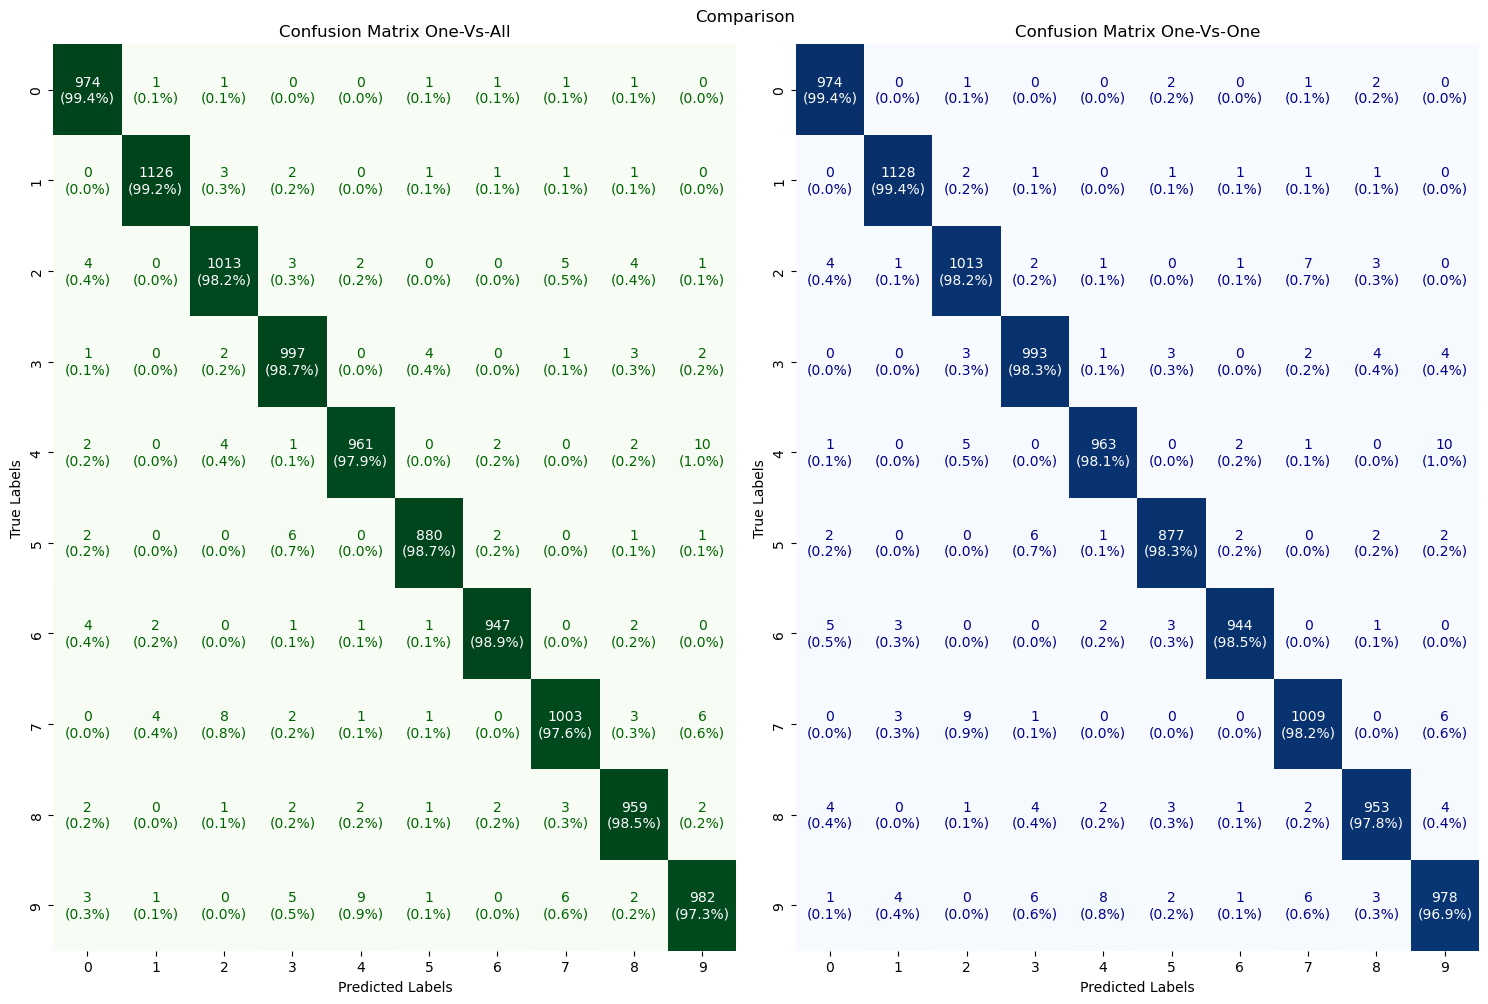

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Preset for faster computations with a subset of 5000 samples.
X_train_subset, _, y_train_subset, _ = train_test_split(X, y, train_size=5000, stratify=y)
# To implement one-vs-all we will need one model for each label. There are 10 digits/labels.
# We use a dictionary to keep the label tied to its model.
one_vs_all_models = {}

# Best values for C and gamma from last task
best_C = 6
best_gamma = 2.6774257317419995e-07
# Generate all labels
labels = [i for i in range(0, 10)]

# Debugging, nice counter for print messages and stuff
i = 0

for label in labels:
  # Convert labels with mask to boolean, then convert boolean to int.
  y_label_ova = (label == y_train_subset).astype(int)

  # Train and store the new binary model, with probability (!)
  svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma, probability=True)
  svm.fit(X_train_subset, y_label_ova)

  one_vs_all_models[label] = svm
  print(f"Trained Model For Label: {label}")

print(f"All {len(labels)} Models Trained.")

# Data structure to save all model predictions to compare later
ova_predictions = []

# Now predict every entry in test data and find the best
for entry in X_test:
  probabilities = []
  for label, model in one_vs_all_models.items():
    # We only need to save the probability for a positive classification.
    # Hence the indexing magic.
    probability = model.predict_proba([entry])[0][1]
    probabilities.append((label, probability))
  
  # Get the max value of the value in tuple pos 1
  # Since we only need the label thats why we extract the first element.
  predicted_label = max(probabilities, key= lambda x:x[1])[0]
  ova_predictions.append(predicted_label)
  
  i += 1
  if i == (len(X_test) / 4):
     print("25% Of Predictions Done...")
  elif i == (len(X_test) / 2):
    print("50% Of Predictions Done...")
  elif i == (len(X_test) * 0.75):
     print("75% Of Predictions Done...")

print("One-Vs-All Predictions finished.")
print("Now Creating One-Vs-One Model For Comparison.")

ovo = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
ovo.fit(X_train_subset, y_train_subset)

print("One-Vs-One Model Done.")
ovo_predictions = ovo.predict(X_test)
print("One-Vs-One Predictions Done.")

print("----------------------------" + "\n" + "Final Score: ")
accuracy_ova = accuracy_score(y_test, ova_predictions)
accuracy_ovo = accuracy_score(y_test, ovo_predictions)
print(f"Accuracy Of One-Vs-All Model: {round((accuracy_ova * 100), 2)}%" + "\n")
print(f"Accuracy Of One-Vs-One Model: {round((accuracy_ovo * 100), 2)}%")

# Get confusion matrix for ova and ovo
conf_matrix_ova = confusion_matrix(y_test, ova_predictions)
conf_matrix_ovo = confusion_matrix(y_test, ovo_predictions)

def calculate_conf_matrix_percentage(confusion_matrix):
   return confusion_matrix/np.sum(confusion_matrix, axis=1, keepdims=True)

# Calculate conf matrix percentage for ova and ovo
percentage_ova_conf_matrix = calculate_conf_matrix_percentage(conf_matrix_ova)
percentage_ovo_conf_matrix = calculate_conf_matrix_percentage(conf_matrix_ovo)


# Plot confusion matrix
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
heatmap = sns.heatmap(percentage_ova_conf_matrix, annot=False, fmt='.1%', cmap='Greens', xticklabels=labels, yticklabels=labels, cbar=False)

# Add custom text to each cell in heatmap. Iterate through the cells
# and calculate percentage and number of classifications for that cell in the conf_matrix
# finally add color to text that has a fitting contrast to the background i.e over 80% classification use white text color.
for i in range(conf_matrix_ova.shape[0]):
    for j in range(conf_matrix_ova.shape[1]):
        count = conf_matrix_ova[i, j]
        percentage = percentage_ova_conf_matrix[i, j]
        text_color = 'white' if percentage_ova_conf_matrix[i, j] > 0.8 else 'darkgreen'
        heatmap.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.1%})",
                     ha='center', va='center', color=text_color, fontsize=10)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix One-Vs-All')

plt.subplot(1,2,2)
heatmap = sns.heatmap(percentage_ovo_conf_matrix, annot=False, fmt='.1%', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

for i in range(conf_matrix_ovo.shape[0]):
    for j in range(conf_matrix_ovo.shape[1]):
        count = conf_matrix_ovo[i, j]
        percentage = percentage_ovo_conf_matrix[i, j]
        text_color = 'white' if percentage_ovo_conf_matrix[i, j] > 0.8 else 'darkblue'
        heatmap.text(j + 0.5, i + 0.5, f"{count}\n({percentage:.1%})",
                     ha='center', va='center', color=text_color, fontsize=10)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix One-Vs-One')

plt.tight_layout()
plt.suptitle('Comparison', y=1)
plt.show()